In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from hierarchical_generalization.make_datasets import generate_phase_train_test_data

## Data

In [2]:
train_data, test_data = generate_phase_train_test_data() 

print(train_data.keys(), test_data.keys())
print(train_data['Phase A'][0].shape, train_data['Phase A'][1].shape) # trials x color x shape

dict_keys(['Phase A', 'Phase B', 'Phase C']) dict_keys(['Phase A', 'Phase B', 'Phase C'])
(120, 5, 4) (120, 4)


In [3]:
train, target = train_data['Phase A']
trial = train[105]
trial

array([[1., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [4]:
def onehot(data):
    """
    input: trials x color x shape
    output: trials x onehotcoding of color and shape
    """
    num_trials = data.shape[0]
    length = data.shape[1] + data.shape[2]
    one_hot = torch.zeros([num_trials, length])
    
    for i in range(num_trials):
        dim0 = data[i].sum(axis=0).argmax()
        dim1 = data[i].sum(axis=1).argmax()
        one_hot[i][dim0] = 1
        one_hot[i][data.shape[1] - 1 + dim1] = 1
        
    return one_hot

In [5]:
onehot(train)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [6]:
def phase_data(phase):
    train_data, test_data = generate_phase_train_test_data()
    train, test = train_data[phase]
    train = onehot(train)
    test = torch.from_numpy(test)
    return train, test

train, test = phase_data('Phase A')
print(train.size(), test.size()) # batch x features; batch x actions

torch.Size([120, 9]) torch.Size([120, 4])


In [7]:
train[7:11]

tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0.]])

In [8]:
test[7:11]

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]], dtype=torch.float64)

## RNN

### Model

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self, batch_size):
        #h0 = torch.randn(self.num_layers, batch_size, self.hidden_size)
        #c0 = torch.randn(self.num_layers, batch_size, self.hidden_size)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return [h0, c0]
    
    def forward(self, x, hidden=None):
        if hidden == None:
            hidden = self.init_hidden(x.size(1))
        else:
            hidden = hidden
        steps = x.size(0) # squence length
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

### Usage refresh

In [10]:
length = 10
input_size = 3
hidden_size = 20
batch_size = 2
num_layers = 1

h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)

x = torch.zeros(length, batch_size, input_size)

lstm_test = nn.LSTM(input_size, hidden_size)
out, hidd = lstm_test(x, [h0, c0])

print(out.size(), hidd[0].size(), hidd[1].size()) # out: length x batch x hidden

torch.Size([10, 2, 20]) torch.Size([1, 2, 20]) torch.Size([1, 2, 20])


### Plot functions

In [11]:
def plot_loss(phase, all_losses):
    """
    all_losses can be an array or a matrix
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.set_title(phase)
    for i in range(len(all_losses)):
        if all_losses[i] < 0.1:
            ax.text(i*0.9, all_losses[i]*1.4, s=(i, str(all_losses[i])[:4]))
            break
    ax.plot(all_losses)
    #ax.text(len(all_losses)*0.9, all_losses[-1]*1.2, s=str(all_losses[-1])[:5], alpha=0.9)

In [12]:
def plot_accuracy(phase, all_accu):
    """
    all_losses can be an array or a matrix
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Blocks')
    ax.set_ylabel('Accuracy')
    ax.set_title(phase)
    for i in range(len(all_accu)):
        if all_accu[i] > 0.9:
            ax.text(i, all_accu[i], s=(i, str(all_accu[i])[:4]))
            break
    ax.plot(all_accu)

## Run!

### Model hyperparameters

In [13]:
train, test = phase_data('Phase A') # batch x features; batch x actions

input_size = train.size(1)
output_size = test.size(1)
hidden_size = 64
batch_size = test.size(0)
num_layers = 1
length = 1

lstm = LSTM(input_size, hidden_size, num_layers, output_size)

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

### Train on PhaseA

In [14]:
h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)
hidden = [h0, c0]

def train_model(phase, hidden=None, transfer=True):
    current_loss = 0
    all_losses = []
    all_accu = []
    n_iters = 2000
    
    for i in range(n_iters):
        train, test = phase_data(phase)
        train = torch.unsqueeze(train, 0)

        output, hidden = lstm(train, hidden=hidden)
        hidden = [h0, hidden[1].detach()]
        
        output = torch.squeeze(output, 0)
        loss = criterion(output, test.argmax(axis=1))
        accuracy = (output.argmax(dim=1) == test.argmax(dim=1)).float()
        accuracy = accuracy.mean()
        if len(all_accu) < 3 or np.mean(all_accu[-3:]) < 0.9:
            all_accu.append(accuracy.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        all_losses.append(loss.item())
        if all_losses[-1] <= 0.05:
            if transfer or i >= 50:
                break
            
    print(i)
    return all_losses, all_accu, hidden 

50


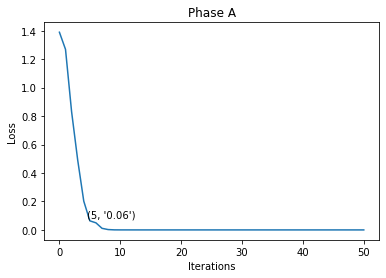

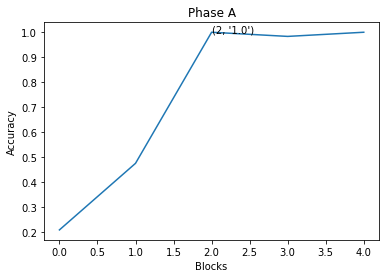

In [15]:
all_lossesA, all_accuA, hidden = train_model('Phase A', hidden, transfer=False)
plot_loss('Phase A', all_lossesA)
plot_accuracy('Phase A', all_accuA)

### Test

Accuracy in Phase A is: 100.00%
Accuracy in Phase B is: 21.67%
Accuracy in Phase C is: 50.00%


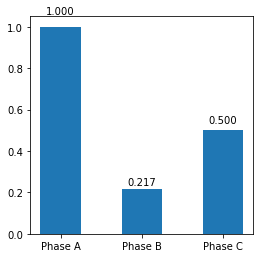

In [16]:
def test_allphase(plot=False):
    phases = ['Phase A', 'Phase B', 'Phase C']
    train_data, test_data = generate_phase_train_test_data()
    all_accu = []
    
    for phase in phases:
        test_input, test_target = test_data[phase]
        test_input = onehot(test_input)
        test_target = torch.from_numpy(test_target)
        #print(test_inputA.size(), test_targetA.size()) # batch x features; batch x actions
    
        with torch.no_grad():
            test_input = torch.unsqueeze(test_input, 0)
            output, _ = lstm(test_input)
            output = torch.squeeze(output, 0)
            accuracy = (output.argmax(dim=1) == test_target.argmax(dim=1)).float()
            accuracy = accuracy.mean()
            all_accu.append(accuracy)
            print(f"Accuracy in {phase} is: {accuracy.item():.2%}")
        
    if plot:
        f, ax = plt.subplots(figsize=(4, 4))
        ax.bar(phases, all_accu, width=0.5)
        for i in range(3):
            ax.text(i, all_accu[i]*1.05, '%.3f' % all_accu[i], ha='center', va= 'bottom')
            
test_allphase(plot=True)

### Transfer phase B

17
Accuracy in Phase A is: 25.00%
Accuracy in Phase B is: 100.00%
Accuracy in Phase C is: 75.00%


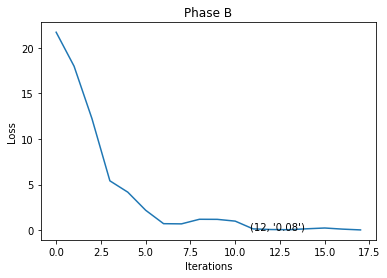

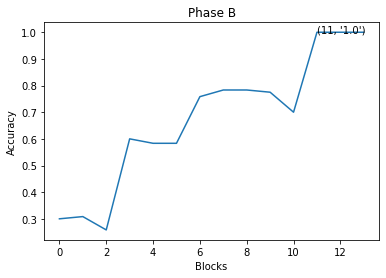

In [17]:
all_lossesB, all_accuB, hidden = train_model('Phase B', hidden)
plot_loss('Phase B', all_lossesB)
plot_accuracy('Phase B', all_accuB)
test_allphase()

In [18]:
test_allphase()

Accuracy in Phase A is: 23.33%
Accuracy in Phase B is: 100.00%
Accuracy in Phase C is: 76.67%


### Transfer phase C

3
Accuracy in Phase A is: 21.67%
Accuracy in Phase B is: 100.00%
Accuracy in Phase C is: 100.00%


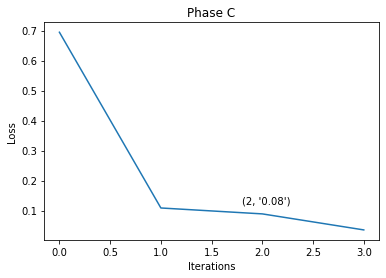

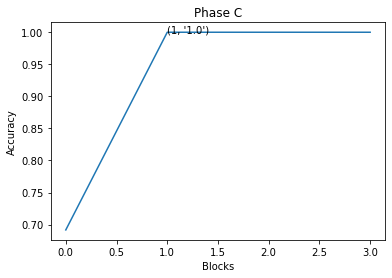

In [19]:
all_lossesC, all_accuC, hidden = train_model('Phase C', hidden)
plot_loss('Phase C', all_lossesC)
plot_accuracy('Phase C', all_accuC)
test_allphase()

In [20]:
test_allphase()

Accuracy in Phase A is: 26.67%
Accuracy in Phase B is: 100.00%
Accuracy in Phase C is: 100.00%


### Learning curve

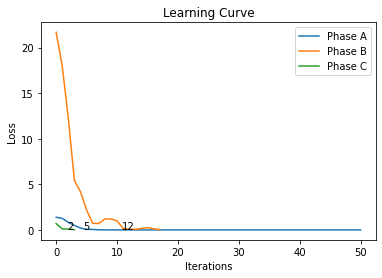

In [21]:
def plot_learningcurve(phases, all_losses):
    """
    all_losses can be an array or a matrix
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.set_title("Learning Curve")
    for j in range(len(phases)):
        all_loss = all_losses[j]
        for i in range(len(all_loss)):
            if all_loss[i] < 0.1:
                ax.text(i*0.9, all_loss[i]*1.3, s=i)
                break
        ax.plot(all_loss, label=phases[j])
        ax.legend()
        
plot_learningcurve(['Phase A', 'Phase B', 'Phase C'], [all_lossesA,all_lossesB,all_lossesC])

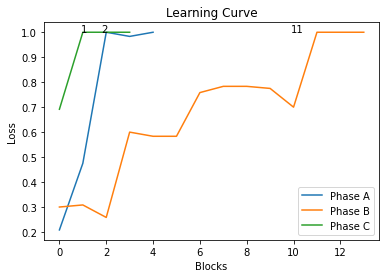

In [22]:
def plot_learning_accu_curve(phases, all_losses):
    """
    all_losses can be an array or a matrix
    """
    f, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Blocks')
    ax.set_ylabel('Loss')
    ax.set_title("Learning Curve")
    for j in range(len(phases)):
        all_loss = all_losses[j]
        for i in range(len(all_loss)):
            if all_loss[i] > 0.9:
                ax.text(i*0.9, all_loss[i], s=i)
                break
        ax.plot(all_loss, label=phases[j])
        ax.legend()
        
plot_learning_accu_curve(['Phase A', 'Phase B', 'Phase C'], 
                  [all_accuA[:30], all_accuB, all_accuC])

## Add layers

### Model hyperparameters

In [23]:
train, test = phase_data('Phase A') # batch x features; batch x actions

input_size = train.size(1)
output_size = test.size(1)
hidden_size = 64
batch_size = test.size(0)
num_layers = 3
length = 1

lstm = LSTM(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)
hidden = [h0, c0]

50
Accuracy in Phase A is: 100.00%
Accuracy in Phase B is: 28.33%
Accuracy in Phase C is: 51.67%


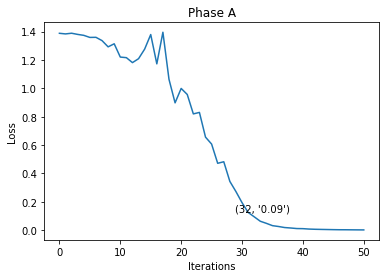

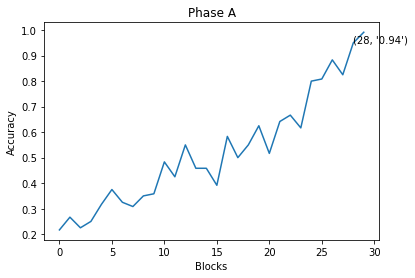

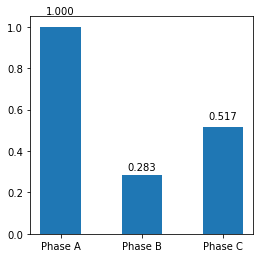

In [24]:
all_lossesA, all_accuA, hidden = train_model('Phase A', hidden, transfer=False)
plot_loss('Phase A', all_lossesA)
plot_accuracy('Phase A', all_accuA)
test_allphase(plot=True)

46
Accuracy in Phase A is: 48.33%
Accuracy in Phase B is: 100.00%
Accuracy in Phase C is: 20.00%


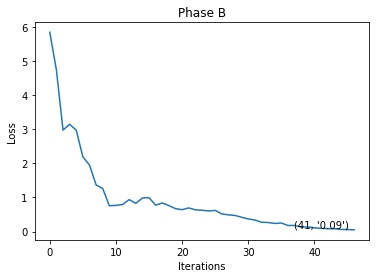

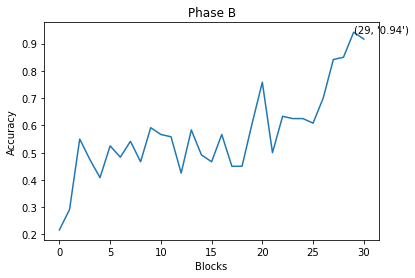

In [25]:
all_lossesB, all_accuB, hidden = train_model('Phase B', hidden)
plot_loss('Phase B', all_lossesB)
plot_accuracy('Phase B', all_accuB)
test_allphase()

23
Accuracy in Phase A is: 25.83%
Accuracy in Phase B is: 66.67%
Accuracy in Phase C is: 100.00%


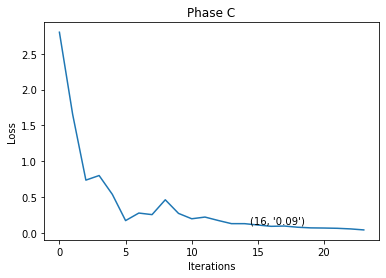

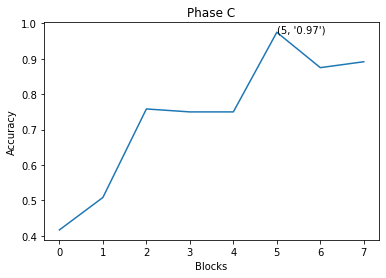

In [26]:
all_lossesC, all_accuC, hidden = train_model('Phase C', hidden)
plot_loss('Phase C', all_lossesC)
plot_accuracy('Phase C', all_accuC)
test_allphase()

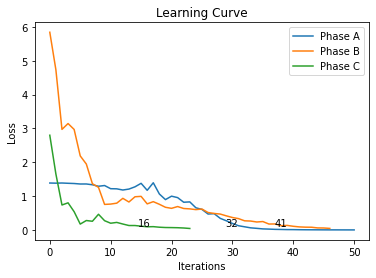

In [27]:
plot_learningcurve(['Phase A', 'Phase B', 'Phase C'], [all_lossesA,all_lossesB,all_lossesC])

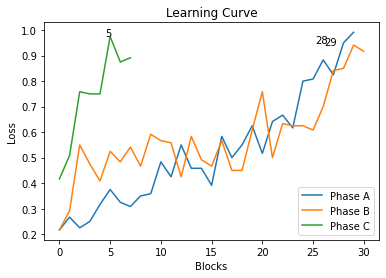

In [28]:
plot_learning_accu_curve(['Phase A', 'Phase B', 'Phase C'], 
                  [all_accuA[:30], all_accuB, all_accuC])